In this project, I am analyzing time series data related to global daily COVID-19 deaths from 2020. I begin by importing the necessary packages for data manipulation, visualization, and modeling, including libraries like pmdarima, statsmodels, and sklearn. After loading the dataset, I extract daily death counts starting from January 22, 2020, and reformat the data into a usable time series structure with dates as the index.

Next, I visualize the cumulative death counts over time and examine the daily increase by computing the difference between consecutive days. I then split the dataset into training and testing sets, using data before July 30, 2020, for training and the remaining data for testing. To model the data, I create a SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors) model, fitting it to the training set to capture the patterns in the time series and forecast future deaths.

Once the model is trained, I generate predictions for the testing period (July 30 to August 13, 2020) and plot these predictions alongside the actual observations to visually assess the model's performance. Finally, I calculate the Mean Absolute Error (MAE) to quantify the accuracy of the SARIMAX model, comparing the predictions to the actual test data to evaluate how well the model performs.

The potential value of this project lies in its ability to provide insights into the trajectory of COVID-19 deaths, aiding public health officials and policymakers in making informed decisions. Accurately forecasting future death counts can help in resource allocation, planning for healthcare capacity, and developing strategies to mitigate the spread of the virus.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install pmdarima

In [27]:
#Importing Packages
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

**Loading the Data**

In [28]:
path = "/content/drive/MyDrive/time_series_covid19_deaths_global.csv"
df = pd.read_csv(path)

df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88


**Data Preprocessing**

First, I extract and process the daily death counts starting from January 22, 2020. I use the iloc function to select all columns from this date onwards, and then I transpose the data to switch rows and columns. I sum the values across the rows (daily death counts for each day) and convert the result to a list called daily_deaths.

Next, I create a new DataFrame called dataset that includes two columns: 'Dates' and 'Deaths'. I convert the date columns from the original dataset to datetime format for the 'Dates' column, and I assign the daily death counts to the 'Deaths' column. Then, I set the 'Dates' column as the index of the DataFrame to make it easier to work with time series data.

To visualize the data, I plot the 'Deaths' column to see how total deaths evolve over time. I make the plot cleaner by hiding the top and right spines (the borders) of the graph.

After that, I calculate the daily increase in deaths by using the diff() function, which computes the difference between each day's death count and the previous day's count. I plot this daily increase in deaths to see how the numbers change day by day, titling the plot "Daily Deaths." I also save this plot as an image file called 'Daily_Deaths.png' for future reference.

Finally, I update the dataset by replacing it with the daily differences (i.e., the daily increase in deaths), and then I filter the data to include only the records between January 23, 2020, and August 13, 2020, narrowing down the time range for analysis.

In [29]:
# Extract columns containing daily death counts from 1/22/20 onwards, transpose the data, and sum row-wise
daily_deaths = df.iloc[:, df.columns.get_loc('1/22/20'):].transpose().sum(axis=1).to_list()

# Create a new dataframe and import data, converting dates to datetime format
dates = pd.to_datetime(df.columns[4:])  # Convert the date columns to datetime format
dataset = pd.DataFrame({'Dates': dates, 'Deaths': daily_deaths}).set_index('Dates')

# Preview the dataset
dataset.head()

,Deaths
Dates,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56


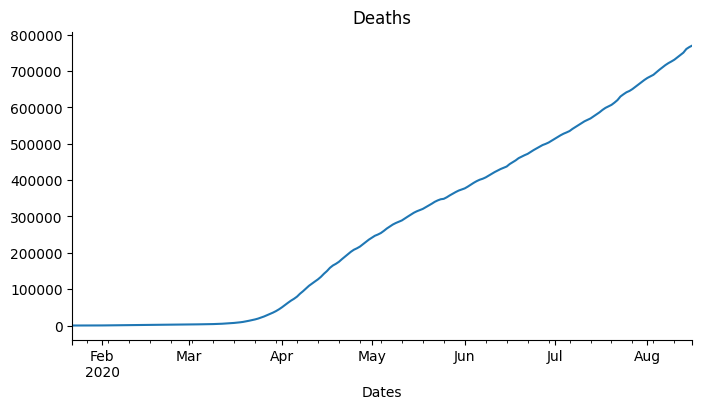

In [30]:
from matplotlib import pyplot as plt
dataset['Deaths'].plot(kind='line', figsize=(8, 4), title='Deaths')
plt.gca().spines[['top', 'right']].set_visible(False)

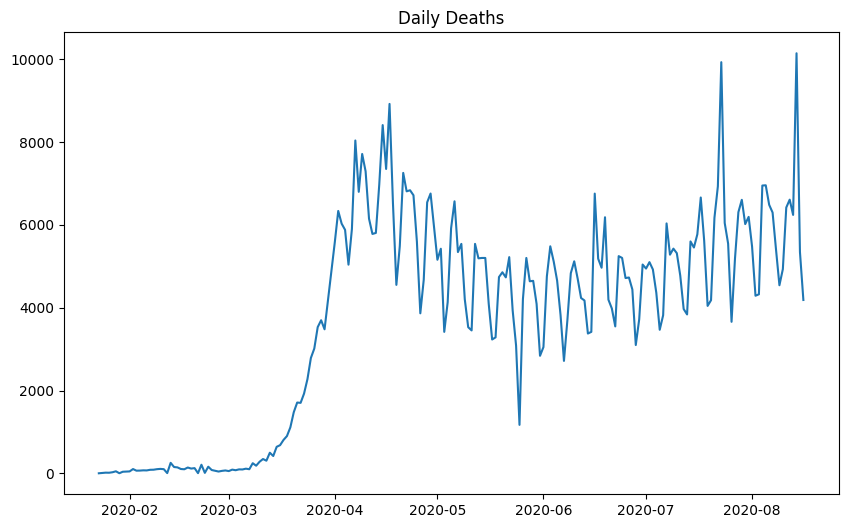

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(dataset.diff()) #to see daily increase
plt.title('Daily Deaths')
plt.savefig('Daily Deaths',
           bbox_inches='tight',
           transparent=False)

In [32]:
#Converting dataset into diff dataset
dataset = dataset.diff()

In [33]:
dataset = dataset.loc['2020-01-23':'2020-08-13']

**SARIMAX Model - Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors Model**



First, I set the start date for splitting the dataset into training and test sets, using '2020-07-30' as the cutoff. I define the training set to include all data before this date and the test set to include all data from this date onward. I then ensure that all columns in the training set are numeric, using pd.to_numeric to coerce any non-numeric values to NaN if necessary. This step ensures that the SARIMAX model can process the data without any issues.

Next, I create a SARIMAX model with the specified order (2, 1, 3)—meaning an autoregressive order of 2, differencing of 1, and a moving average order of 3. I then fit the model to the training data and use it to predict values from the start date until August 13, 2020. After fitting and predicting, I plot both the observed data and the SARIMAX predictions on the same graph to visually compare the model's performance with the actual data. I also save this plot as an image file called 'SARIMAX_Prediction.png' for later use.

Then, I calculate the Mean Absolute Error (MAE) between the predictions and the test set to evaluate the model’s accuracy. The MAE helps me quantify how well the SARIMAX model performed by measuring the average absolute difference between predicted and actual values. I print the MAE to understand how close my predictions are to the real data.

Finally, I fit an auto ARIMA model on the training data using the pm.auto_arima() function. I specify initial values for the autoregressive and moving average terms (p and q) and let the model use the ADF test to find the optimal level of differencing (d). I limit the maximum values for p and q to 3, disable seasonality, and use the stepwise algorithm to efficiently search for the best model. The trace is enabled so I can monitor the model selection process, and I suppress any non-fatal errors to keep the output clean. Once the model is fit, I print the summary to see its details, including the chosen parameters and performance metrics.

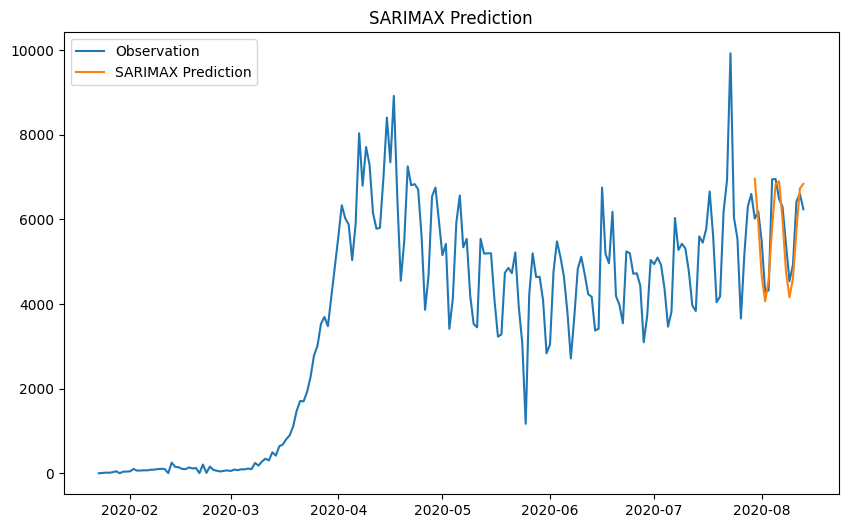

In [34]:
# Set start date
start_date = '2020-07-30'

# Define train and test sets based on the date index
train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

# Ensure all columns in train set are numeric (in-place operation to avoid warnings)
train = train.apply(pd.to_numeric, errors='coerce')

# Create and fit SARIMAX model
model = SARIMAX(train, order=(2, 1, 3))
results = model.fit(disp=False)

# Predict from start_date to the specified end date
sarimax_prediction = results.predict(start=start_date, end='2020-08-13', dynamic=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dataset, label='Observation')
plt.plot(sarimax_prediction, label='SARIMAX Prediction')
plt.title('SARIMAX Prediction')
plt.legend()

# Save plot
plt.savefig('SARIMAX_Prediction.png', bbox_inches='tight', transparent=False)
plt.show()

In [35]:
# Calculate and print the Mean Absolute Error (MAE) between predictions and test set
sarimax_mae = mean_absolute_error(test, sarimax_prediction)
print(f'SARIMAX MAE: {sarimax_mae:.4f}')

SARIMAX MAE: 482.3860


The output SARIMAX MAE: 482.3860 indicates that, on average, the predictions made by the SARIMAX model deviate from the actual daily death counts by approximately 482 deaths.

In [36]:
# Fit an auto ARIMA model on the training data
model = pm.auto_arima(
    train,
    start_p=1, start_q=1,  # Initial p and q values
    test='adf',            # Use ADF test to find the optimal value of 'd'
    max_p=3, max_q=3,      # Maximum values for p and q
    m=1,                   # Frequency of the time series (non-seasonal)
    d=None,                # Automatically determine the order of differencing
    seasonal=False,        # No seasonality
    trace=True,            # Enable trace for model selection process
    error_action='ignore', # Ignore non-fatal errors
    suppress_warnings=True,
    stepwise=True          # Use stepwise algorithm to search for the best model
)

# Print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3096.367, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3116.343, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3117.774, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3117.349, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3114.601, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3083.891, Time=2.88 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3112.436, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3074.186, Time=3.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3101.050, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3028.134, Time=3.65 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3024.714, Time=7.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3090.746, Time=1.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3010.175, Time=4.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : 

Best model:  ARIMA(2,1,3)(0,0,0)[0]    

In summary, the output indicates that the best model identified for the data is a non-seasonal ARIMA model with two autoregressive terms, one degree of differencing, and three moving average terms. It also does not account for any seasonal effects.